# Enhancing Mental Health: Stress Level Prediction through a Machine Learning and NLP Approach


## Importing Libraries

In [139]:
import sys
import keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import numpy as np
import platform

print (f"Python Platform: {platform.platform ()}")
print (f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print ()

print (f"Python {sys.version}")
print (f"Pandas {pd.__version__}")
print (f"Scikit-Learn {sk.__version__}")
print (f"SciPy {sp.__version__}")
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.2-arm64-arm-64bit
Tensor Flow Version: 2.16.1
Keras Version: 3.2.1

Python 3.11.7 (main, Dec 15 2023, 12:09:56) [Clang 14.0.6 ]
Pandas 2.2.2
Scikit-Learn 1.2.2
SciPy 1.13.0
GPU is available


### Loading Dataset

In [2]:
# Load CSV file into a DataFrame

df = pd.read_csv('mental_health.csv')

# Display the DataFrame
df.head(20)

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
5,hey rredflag sure right place post this goes ...,1
6,feel like someone needs hear tonight feeling r...,0
7,deserve liveif died right noone would carei re...,1
8,feels good ive set dateim killing friday nice ...,1
9,live guiltok made stupid random choice its ge...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27977 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27977 non-null  object
 1   label   27977 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 437.3+ KB


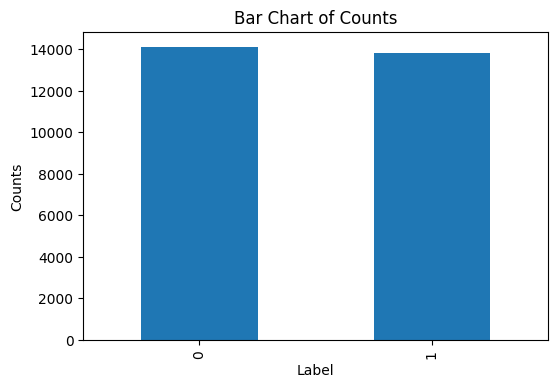

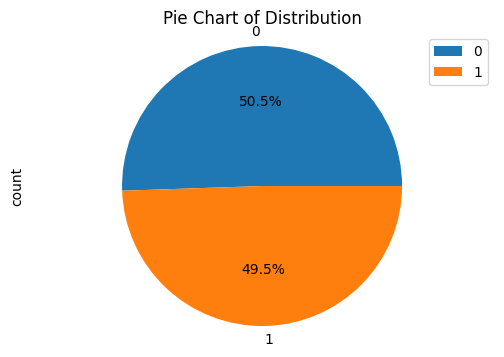

In [4]:
import matplotlib.pyplot as plt

# Calculate the value counts of the 'category' column
category_counts = df['label'].value_counts()

# Bar chart
plt.figure(figsize=(6, 4))
category_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Bar Chart of Counts')
plt.show()
print()

# Pie chart
plt.figure(figsize=(6, 4))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Pie Chart of Distribution')

# Add legend
plt.legend()

plt.show()


## **Duplicates and Missing Values**

Next, we'll evaluate the dataset's size and search for any duplicate rows within the DataFrame. We'll achieve this by counting the duplicates and displaying the results. Handling duplicate rows is crucial as they can distort our analysis. Additionally, we'll check for missing values by calculating and printing the sum of missing values for each column. Properly addressing missing values is essential to ensure the accuracy and reliability of our analysis.

In [5]:
# How many reviews do we have?
print('There are', df.shape[0], 'data in this dataset')

#Dupicate Check?
print('Number of Duplicates:', len(df[df.duplicated()]))

# Missing Values Check
missing_values = df.isnull().sum()
print('Number of Missing Values by column:\n',missing_values)

print('Number of Missing Values:', df.isnull().sum().sum())

There are 27977 data in this dataset
Number of Duplicates: 5
Number of Missing Values by column:
 text     0
label    0
dtype: int64
Number of Missing Values: 0


In [6]:
df.replace("", np.nan, inplace=True)
missing_values = df.isnull().sum()
print('No. of Missing Values and Empty Spaces by column:\n',missing_values)

No. of Missing Values and Empty Spaces by column:
 text     0
label    0
dtype: int64


In [7]:
# all duplicate rows (keep=False ensures all duplicates are kept)
duplicate_rows = df[df.duplicated(keep=False)]

# Then sort the dataframe on all columns to ensure duplicates are adjacent
sorted_duplicates = duplicate_rows.sort_values(by=list(duplicate_rows.columns))

# Now, if we want to see 5 pairs of duplicates (10 rows), we can simply:
top_5_duplicate_pairs = sorted_duplicates.head(20)

top_5_duplicate_pairs

,text,label
15524,happy birthday everyone birthday st october ha...,0
24502,happy birthday everyone birthday st october ha...,0
16742,need help anyone good pythagriam tribometry h...,0
24970,need help anyone good pythagriam tribometry h...,0
1646,posting ara ara forget day ara ara,0
22603,posting ara ara forget day ara ara,0
11570,real suppleroot hours up day far,0
12573,real suppleroot hours up day far,0
22389,real suppleroot hours up day far,0


### **Drop Duplicates**

In [8]:
df = df.drop_duplicates()
print('Number of Duplicates:', len(df[df.duplicated()]))

Number of Duplicates: 0


### **Drop Missing Values**

In [9]:
df = df.dropna()
print('Number of Missing Values:', df.isnull().sum().sum())

Number of Missing Values: 0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27972 entries, 0 to 27976
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    27972 non-null  object
 1   label   27972 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 655.6+ KB


**View random samples for each category**

Here, a function called "random_sample_reviews" is defined to randomly sample text from the DataFrame based on the specified number of samples. This function groups the text by label and selects a specified number of samples from each label. The sampled reviews are then returned as a DataFrame. This function helps in obtaining a representative subset of reviews for analysis.

In [11]:
def random_sample_reviews(df, num_samples):
    # Use groupby on 'Rating' and then apply the sample function to 'Review_Text' of each group
    samples = df.groupby('label')['text'].apply(lambda x: x.sample(num_samples))

    # Convert series to dataframe and reset index
    samples_df = samples.reset_index().drop(columns='level_1')
    return samples_df
    
pd.set_option('display.max_colwidth', 200) # This will display up to 100 characters
samples = random_sample_reviews(df, num_samples=3)
samples.head(20)

,label,text
0,0,lesser known film starring roy thinnes from tvs invaders actually consider lost gem made time story important special effects though effect fairly good time scientist theorizes another world earth...
1,0,cant seem make friends honestly cant make friends feels like matter do happen well id say one friend who love much appreciate every day couple people occasionally talk like aside nobody strangers ...
2,0,mess genres mainly based stephen chows genre mashups inspiration theres magic kungfu college romance sports gangster action weepy melodrama topping production excellent pacing fast easy get past m...
3,1,im ready take forever napi reasons continue hold onto bullshit life cant myself family fucking garbage nobody would believe tried escape them fucking mess mention fact ive fucking havent able onli...
4,1,record suicidal never been going tell something true story might make think another wayfor background moms friend call susan speaks russian english works translation hospitals youssusan client cal...
5,1,know whats funnyhow people fucking tell shit care truth care dead people supposed make feel safe fucking make feel worse fucking hope feel guilty lost fucking horrible damage inflicted onto never ...


## **Data Cleaning**

In [12]:
#libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics

import re
import string

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [13]:
##CUSTOM FUNCTIONS TO CLEAN THE TEXT
def emoji_strip(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese characters
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Remove punctuations, links, mentions and \r\n new line characters
def remove_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def hastag_cleaning(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    return new_text2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [14]:
df['text1'] = (df['text']
                     .apply(emoji_strip)
                     .apply(remove_entities)
                     .apply(hastag_cleaning)
                     .apply(filter_chars)
                     .apply(remove_spaces))

In [15]:
df.head()

,text,label,text1
0,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,0,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math
1,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself,1,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself
2,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,0,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...
3,im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost take meds go therapy no...,1,im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost take meds go therapy not...
4,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electro...,1,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electroni...


Let's compare the original and cleaned text data and analyze the impact of text cleaning on the text length.

In [17]:
df_compare = pd.DataFrame()

# Original text and its length
df_compare['pre-clean text'] = df['text']
df_compare['pre-clean len'] = df['text'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_compare['post-clean text'] = df['text1']
df_compare['post-clean len'] = df['text1'].apply(lambda x: len(str(x).split()))

df_compare.head(10)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,23,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,23
1,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself,20,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself,20
2,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,64,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,64
3,im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost take meds go therapy no...,100,im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost take meds go therapy not...,100
4,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electro...,311,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electroni...,311
5,hey rredflag sure right place post this goes im currently student intern sandia national labs working survey help improve marketing outreach efforts many schools recruit around country were looki...,61,hey rredflag sure right place post this goes im currently student intern sandia national labs working survey help improve marketing outreach efforts many schools recruit around country were lookin...,61
6,feel like someone needs hear tonight feeling right think cant anything people keep puting listen this its your life everyone else living it someone tells unable something work get done say wrong s...,79,feel like someone needs hear tonight feeling right think cant anything people keep puting listen this its your life everyone else living it someone tells unable something work get done say wrong s...,79
7,deserve liveif died right noone would carei real friendsi always start conversations get dry responses i feel comfortable around females emotional abuse mom put left usi never find love i keep get...,51,deserve liveif died right noone would carei real friendsi always start conversations get dry responses i feel comfortable around females emotional abuse mom put left usi never find love i keep get...,51
8,feels good ive set dateim killing friday nice finally know im gonna it bye,14,feels good ive set dateim killing friday nice finally know im gonna it bye,14
9,live guiltok made stupid random choice its getting me basically molested relative super erratic thing haunting right now random walk home randomly assaulted classmate screamed name loud pretty mu...,66,live guiltok made stupid random choice its getting me basically molested relative super erratic thing haunting right now random walk home randomly assaulted classmate screamed name loud pretty muc...,66


## **Remove Stopwords**

In [18]:
def rm_stopwords(sentence):
    
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    # Sentence converted to lowercase-only
    sentence = sentence.lower()

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence

In [19]:
df['text2'] = (df['text1'].apply(rm_stopwords))

compare the original and stopwords-removed text data and analyze the impact of removing stopwords on the text length.

In [20]:
df_comp = pd.DataFrame()

# Original text and its length
df_comp['pre-clean text'] = df['text1']
df_comp['pre-clean len'] = df['text1'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_comp['post-clean text'] = df['text2']
df_comp['post-clean len'] = df['text2'].apply(lambda x: len(str(x).split()))

df_comp.head(5)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,23,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,23
1,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang myself,20,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang,19
2,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,64,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,61
3,im done trying feel betterthe reason im still alive know mum devastated ever killed myself ever passes im still state im going hesitate ending life shortly after im almost take meds go therapy not...,100,im done trying feel betterthe reason im still alive know mum devastated ever killed ever passes im still state im going hesitate ending life shortly im almost take meds go therapy nothing seems he...,96
4,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electroni...,311,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electroni...,296


## **Lemmatization**

In [21]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    # Tokenize the sentence
    word_list = nltk.word_tokenize(text)

    # Lemmatize list of words and join
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])

    return lemmatized_output

[nltk_data] Downloading package wordnet to /Users/raja/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/raja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The lemmatization function is then applied to the 'text2' column of the DataFrame 'df' using the apply method, and the lemmatized output is assigned to the 'text3' column.

In [22]:
df['text3'] = df['text2'].apply(lemmatize_text)

A new DataFrame, 'df_lemma', is created to store the original and lemmatized text data along with their respective lengths.

In [23]:
df_lemma = pd.DataFrame()

# Original text and its length
df_lemma['pre-clean text'] = df['text2']
df_lemma['pre-clean len'] = df['text2'].apply(lambda x: len(str(x).split()))

# Cleaned text and its length
df_lemma['post-clean text'] = df['text3']
df_lemma['post-clean len'] = df['text3'].apply(lambda x: len(str(x).split()))

df_lemma.head(20)

,pre-clean text,pre-clean len,post-clean text,post-clean len
0,dear american teens question dutch person heard guys get way easier things learn age us sooooo thth graders like right guys learn math,23,dear american teen question dutch person heard guy get way easier thing learn age u sooooo thth grader like right guy learn math,23
1,nothing look forward lifei dont many reasons keep going feel like nothing keeps going next day makes want hang,19,nothing look forward lifei dont many reason keep going feel like nothing keep going next day make want hang,19
2,music recommendations im looking expand playlist usual genres alt pop minnesota hip hop steampunk various indie genres artists people like cavetown aliceband bug hunter penelope scott various rhym...,61,music recommendation im looking expand playlist usual genre alt pop minnesota hip hop steampunk various indie genre artist people like cavetown aliceband bug hunter penelope scott various rhymesay...,61
3,im done trying feel betterthe reason im still alive know mum devastated ever killed ever passes im still state im going hesitate ending life shortly im almost take meds go therapy nothing seems he...,96,im done trying feel betterthe reason im still alive know mum devastated ever killed ever pass im still state im going hesitate ending life shortly im almost take med go therapy nothing seems help ...,97
4,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl years lives uk live different country kept touch electroni...,296,worried year old girl subject domestic physicalmental housewithout going lot know girl know girl etc let give brief background known girl year life uk live different country kept touch electronic ...,296
5,hey rredflag sure right place post goes im currently student intern sandia national labs working survey help improve marketing outreach efforts many schools recruit around country looking current ...,57,hey rredflag sure right place post go im currently student intern sandia national lab working survey help improve marketing outreach effort many school recruit around country looking current under...,57
6,feel like someone needs hear tonight feeling right think cant anything people keep puting listen life everyone else living someone tells unable something work get done say wrong someone says youl ...,69,feel like someone need hear tonight feeling right think cant anything people keep puting listen life everyone else living someone tell unable something work get done say wrong someone say youl nev...,69
7,deserve liveif died right noone carei real friendsi always start conversations get dry responses feel comfortable around females emotional abuse mom put left usi never find love keep getting remin...,47,deserve liveif died right noone carei real friendsi always start conversation get dry response feel comfortable around female emotional abuse mom put left usi never find love keep getting reminded...,47
8,feels good ive set dateim killing friday nice finally know im gonna bye,13,feel good ive set dateim killing friday nice finally know im gon na bye,14
9,live guiltok made stupid random choice getting basically molested relative super erratic thing haunting right now random walk home randomly assaulted classmate screamed name loud pretty much annoy...,62,live guiltok made stupid random choice getting basically molested relative super erratic thing haunting right now random walk home randomly assaulted classmate screamed name loud pretty much annoy...,62


### **Text Length**

In [24]:
df['text_length'] = df['text3'].apply(lambda x: len(str(x).split()))

In [25]:
# Calculate the length of each text in X_train
text_lengths = [len(text.split()) for text in df["text3"]]

# Find the 95th quartile
quartile_95 = np.percentile(text_lengths, 95)

print(f"95th Quartile of Text Lengths: {quartile_95}")

95th Quartile of Text Lengths: 231.0


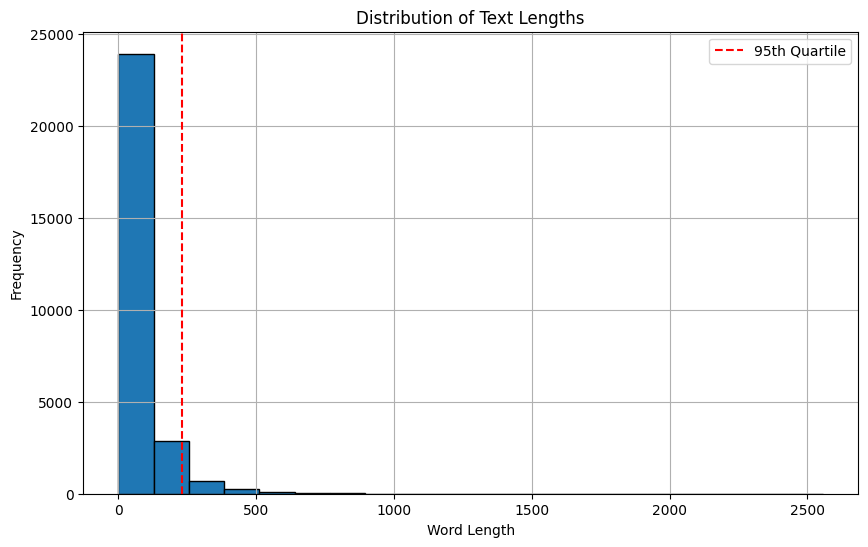

In [26]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')

# Adding a vertical line for the 95th quartile
quartile_95 = np.percentile(text_lengths, 95)
plt.axvline(x=quartile_95, color='red', linestyle='--', label='95th Quartile')
plt.legend()

plt.grid(True)
plt.show()

In [27]:
df.text_length.describe()

count    27972.000000
mean        68.121014
std         97.784015
min          0.000000
25%         15.000000
50%         36.000000
75%         82.000000
max       2556.000000
Name: text_length, dtype: float64

### **Visualize text with low frequency words**

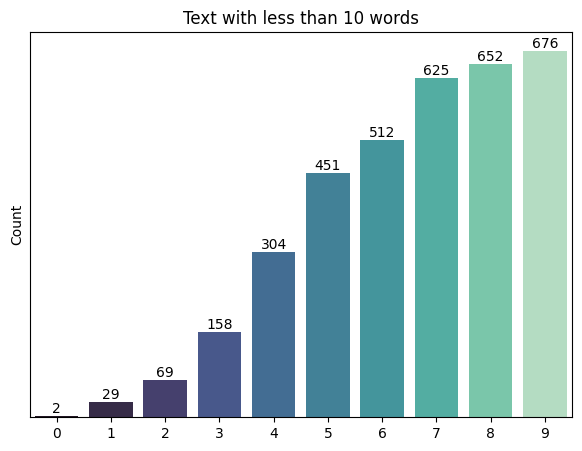

In [28]:
import seaborn as sns

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_length', data=df[df['text_length']<10], palette='mako')
plt.title('Text with less than 10 words')
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('Count')
plt.xlabel('')
plt.show()

#### A subset of the DataFrame 'df' is created

In [29]:
data_head=df[df['text_length']<2] # rows where the text length is less than 2
data_head.head(30)

,text,label,text1,text2,text3,text_length
654,sleep,0,sleep,sleep,sleep,1
1811,karent,0,karent,karent,karent,1
2781,male,0,male,male,male,1
3354,cthgisnialpnidenodnabamocefilretfalarutcetihcrasptth,1,cthgisnialpnidenodnabamocefilretfalarutcetihcrasptth,cthgisnialpnidenodnabamocefilretfalarutcetihcrasptth,cthgisnialpnidenodnabamocefilretfalarutcetihcrasptth,1
3626,enoughhttpimgurcomhqermql,1,enoughhttpimgurcomhqermql,enoughhttpimgurcomhqermql,enoughhttpimgurcomhqermql,1
4094,whiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelya...,1,whiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelya...,whiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelya...,whiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelyankeemikeechowhiskeyhotelya...,1
4578,name,1,name,name,name,1
4743,hello,1,hello,hello,hello,1
4837,something,0,something,something,something,1
6579,,0,,,,0


In [30]:
len(df)

27972

In [31]:
df = df[df['text_length'] >= 3]

In [32]:
len(df)

27872

**Drop the columns and shuffle**

In [33]:
df = df.drop(['text', 'text1', 'text2'], axis=1)

In [34]:
# Shuffle training dataframe
df = df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
df.head(30)

,label,text3,text_length
10110,0,video picture death video photo always death youll eventually die youll already taken video solved clickbait video video taken death thank later,22
16118,0,help help commenting post want orange mail pls,8
4336,1,anyone talk toi need someone talk situation,7
7496,1,tonightno shitty life bad circumstance no im lazy incompetent unsuccessful nothing happened beyond normal im done living want anymore ive downward spiral since im now shit together im well way ish...,147
7954,1,anyone feel like life force throati feel like everything life force upon im forced act way way im forced go school im forced work job passion im forced smile im forced cry im forced get married ki...,84
25377,0,anyone else absolutely hate situation mean getting scolded parent remaining calm trying explain everything time finally getting annoyed situation exact second turn theyre calm nowhere trying act l...,40
17739,0,anyone want silver idk whoever comment first ig,8
1762,1,destined failure tragedy mom dy im year old im beside dy pneumonia breast cancer chemo fail law school year debt age got pregnant gave birth month daughter dy hour alive cousin age gave birth heal...,132
21839,0,karma hit today cake make,5
26355,1,last year sold beautiful condominium foolish use mind time cat got sick one passed away one week later due move new vet killed got sick needed help given taken mental hospital police vet told poli...,69


In [35]:
df.label.value_counts()

label
0    14074
1    13798
Name: count, dtype: int64

In [36]:
# Define data
data = {
    'Label': ["Non-mental-health", "Mental-health"],
    'Label Encoded': [0,1]
}

# Create DataFrame
dr = pd.DataFrame(data)

# Print DataFrame
dr

,Label,Label Encoded
0,Non-mental-health,0
1,Mental-health,1


In [37]:
class_names=dr.Label.to_list()
class_names

['Non-mental-health', 'Mental-health']

## **Define Features, X & Labels, y**

In [38]:
X = df['text3'].to_numpy()
y = df['label'].to_numpy()

## Split the Data

In [39]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((22297,), (5575,), (22297,), (5575,))

In [41]:
# Check the lengths
len(X_train), len(X_valid), len(y_train), len(y_valid)

(22297, 5575, 22297, 5575)

In [45]:
X_train

array(['im scared myselfi live life filled depression go school ignored come home ignored want someone hear im almost done everything im close breaking point able turn back im tired ignored want hear',
       'ive felt dead longer ive felt alivei never happy kid painfully vivid memory raped young kid memory head slammed wall floor even distinct memory concussion one time slammed hard ground head ended bouncing hitting metal support bed day im scared men man imy first attempt kill around time failed inexperienced kid second time tried kill around time caught complete mental breakdown mom stay local mental hospital day try get help opened nice lady help rationalize fear hospital feeling broken tool ready thrown away butthats also gave trying thing general stopped trying school beyond minimum effort required pas stopped really associating friend school everything painfully mediocre year around time parent finally let liberty complaining year never hung friend like ever let first place hel

In [46]:
y_train, y_valid

(array([1, 1, 1, ..., 0, 0, 1]), array([0, 0, 1, ..., 1, 0, 1]))

To determine the typical length of training texts, we calculate the average number of tokens (words) per text. This measurement aids in selecting an appropriate input size for neural network models, ensuring they are tailored to handle the data effectively.

In [47]:
# Find average number of tokens (words) in training texts
round(sum([len(i.split()) for i in X_train])/len(X_train))

68

In [48]:
# Calculate the length of each text in X_train
text_lengths = [len(text.split()) for text in X_train]

# Find the 98th percentile
percentile_95 = np.percentile(text_lengths, 95)

print(f"95th Percentile of Text Lengths: {percentile_95}")

95th Percentile of Text Lengths: 232.0


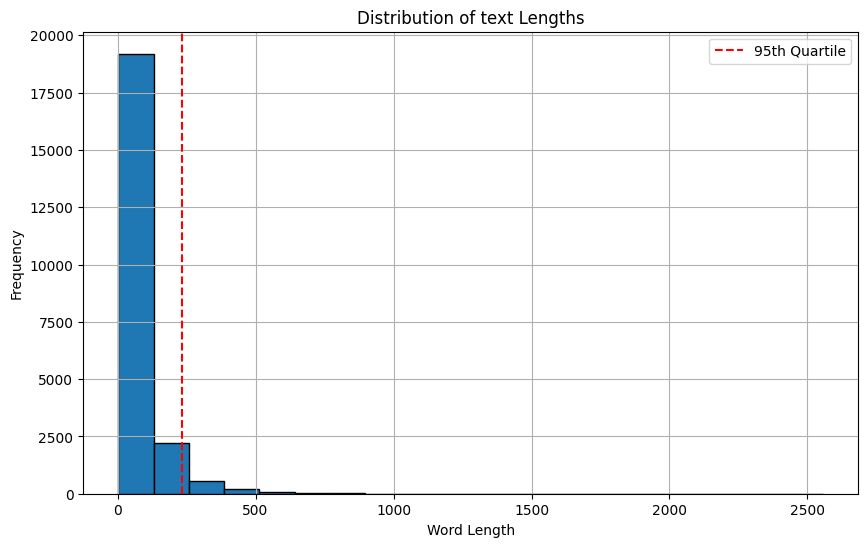

In [49]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=20, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of text Lengths')

# Adding a vertical line for the 95th quartile
quartile_95 = np.percentile(text_lengths, 95)
plt.axvline(x=quartile_95, color='red', linestyle='--', label='95th Quartile')
plt.legend()

plt.grid(True)
plt.show()

We calculate the maximum text length to identify the longest sequence that the model can process. This is crucial for deciding how to pad or truncate sequences during the preprocessing stage, ensuring all inputs are uniform in length.

In [50]:
max_text_length = max(text_lengths)
print(f"Maximum Text Length: {max_text_length}")

Maximum Text Length: 2556


## **Text Vectorization**

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Setup text vectorization with custom variables
max_vocab_length =None # max number of words to have in our vocabulary
max_length = int(percentile_95) # max length our sequences will be (e.g. how many words from a text does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

2024-04-13 15:55:18.783273: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-04-13 15:55:18.783318: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-04-13 15:55:18.783325: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-04-13 15:55:18.783364: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-13 15:55:18.783394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


The text vectorizer is fitted to the training text to build the vocabulary based on the training data. This allows the vectorizer to learn the mapping between words and their integer representations.

In [52]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [53]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 58460
Top 5 most common words: ['', '[UNK]', 'im', 'like', 'want']
Bottom 5 least common words: ['aaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaa', 'aaaaaaaa', 'aaaaa']


The maximum vocabulary length is updated with the actual length of the vocabulary obtained from the text vectorizer.

In [54]:
max_vocab_length=len(words_in_vocab)

# **Model: Baseline**

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
baseline_model = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Now fit the model
baseline_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [56]:
baseline_score = baseline_model.score(X_valid, y_valid)
print(f" Baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

 Baseline model achieves an accuracy of: 85.43%


In [57]:
# Make predictions
baseline_preds = baseline_model.predict(X_valid)
baseline_preds[:20]

array([0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

Then a function calculate_results is defined to calculate the accuracy, precision, recall, and F1 score of the model's predictions.

In [58]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
 
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

The function is used to calculate the results of the baseline model and these are printed out.

In [59]:
# baselineModel results
baseline_results = calculate_results(y_true=y_valid,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 85.43497757847534,
 'precision': 0.881010158721504,
 'recall': 0.8543497757847534,
 'f1': 0.8519790697475407}

In [60]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

**Callbacks**

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_checkpoint_callback(checkpoint_path):
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                          monitor='val_accuracy',
                                          mode='max',
                                          save_best_only=True,
                                          verbose=1)
    return checkpoint_callback

**Embedding layer**

In [62]:
import tensorflow_hub as hub
from tensorflow.keras import layers

In [65]:
# from tensorflow.keras import layers

tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=300, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

/Users/raja/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

# **Model: LSTM**

In [67]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
lstm_model_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=300,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = lstm_model_embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the text (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
lstm_model = tf.keras.Model(inputs, outputs, name="lstm_model")

(None, 232, 300)
(None, 64)


In [68]:
# Compile model
lstm_model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [69]:
lstm_model.summary()

Model: "lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 232)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 232, 300)       │    17,538,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 232, 64)        │        93,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,668,689 (67.40 MB)

 Trainable params: 17,668,689 (67.40 MB)

 Non-trainable params: 0 (0.00 B)

We now create a checkpoint callback for model LSTM.

In [70]:
# Define the checkpoint path
checkpoint_path = "best_model_Bi-LSTM.keras"

cc = create_checkpoint_callback(checkpoint_path)

In [71]:
# Fit model
lstm_model_history = lstm_model.fit(X_train, y_train,
                              epochs=10,
                              validation_data=(X_valid, y_valid),
                              callbacks=[cc])

Epoch 1/10


2024-04-13 16:11:06.790205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5370 - loss: 0.6790
Epoch 1: val_accuracy improved from -inf to 0.52700, saving model to best_model_Bi-LSTM.keras
697/697 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - accuracy: 0.5370 - loss: 0.6790 - val_accuracy: 0.5270 - val_loss: 0.6909
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6397 - loss: 0.5831
Epoch 2: val_accuracy improved from 0.52700 to 0.90475, saving model to best_model_Bi-LSTM.keras
697/697 ━━━━━━━━━━━━━━━━━━━━ 45s 64ms/step - accuracy: 0.6398 - loss: 0.5829 - val_accuracy: 0.9048 - val_loss: 0.2584
Epoch 3/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9253 - loss: 0.1997
Epoch 3: val_accuracy improved from 0.90475 to 0.91552, saving model to best_model_Bi-LSTM.keras
697/697 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9253 - loss: 0.1997 - val_accuracy: 0.9155 - val_loss: 0.2254
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9667 - loss: 0.0981
Epoch 4: val_accur

Following training, the history of LSTM model's accuracy and loss over the epochs is plotted.

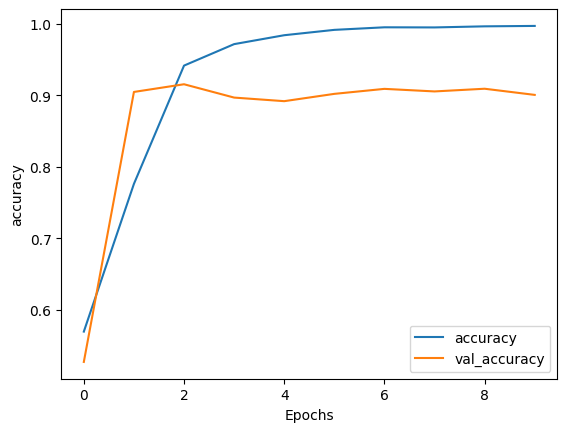

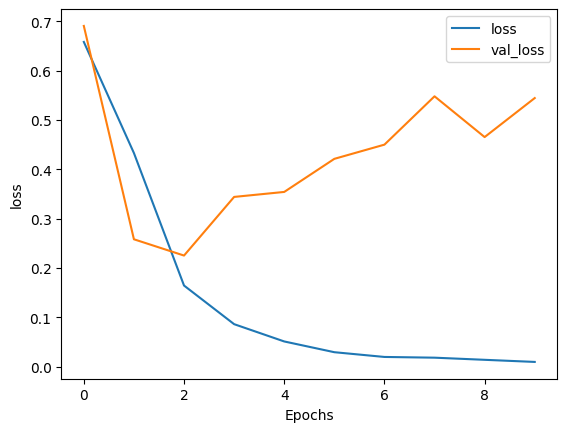

In [72]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(lstm_model_history, 'accuracy')
plot_graphs(lstm_model_history, 'loss')

In [74]:
from tensorflow.keras.models import load_model

# Load the entire model
lstm_model = load_model(checkpoint_path)

The LSTM model is evaluated on the validation set to understand its performance on unseen data.

In [75]:
lstm_model.evaluate(X_valid, y_valid)

175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9104 - loss: 0.2309


[0.22536934912204742, 0.9155157208442688]

In [76]:
# Make predictions on the validation dataset
lstm_model_pred_probs = lstm_model.predict(X_valid)
lstm_model_pred_probs.shape, lstm_model_pred_probs[:10] # view the first 10

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


((5575, 1),
 array([[0.00646534],
        [0.00192491],
        [0.9809474 ],
        [0.03597093],
        [0.67051554],
        [0.97818726],
        [0.98397255],
        [0.98496115],
        [0.7622405 ],
        [0.22307119]], dtype=float32))

In [77]:
# Convert prediction probabilities to labels
lstm_model_preds = tf.squeeze(tf.round(lstm_model_pred_probs))
lstm_model_preds[:10]


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Metrics such as accuracy, precision, recall, and F1-score are calculated to evaluate the performance of the LSTM model.

In [78]:
# Calculate LSTM model results
lstm_model_results = calculate_results(y_true=y_valid,
                                    y_pred=lstm_model_preds)
lstm_model_results

{'accuracy': 91.55156950672647,
 'precision': 0.9155406811826331,
 'recall': 0.9155156950672646,
 'f1': 0.9155175544145038}

The function compares the performance metrics of the baseline model with the LSTM model. The comparison include various metrics such as accuracy, precision, recall, and F1-score.

In [79]:
# Compare model ltsm to baseline
compare_baseline_to_new_results(baseline_results, lstm_model_results)

Baseline accuracy: 85.43, New accuracy: 91.55, Difference: 6.12
Baseline precision: 0.88, New precision: 0.92, Difference: 0.03
Baseline recall: 0.85, New recall: 0.92, Difference: 0.06
Baseline f1: 0.85, New f1: 0.92, Difference: 0.06


In [80]:
y_true = y_valid.tolist()  # Convert labels to a list
preds = lstm_model.predict(X_valid)
y_probs = preds.squeeze().tolist()  # Store the prediction probabilities as a list
y_preds = tf.round(y_probs).numpy().tolist()  # Convert probabilities to class predictions and convert to a list


175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


A confusion matrix is generated to visualize the classification performance of the LSTM model. A custom function is used to make the matrix more readable.

In [81]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_true,
                 y_pred=y_preds)

array([[2570,  245],
       [ 226, 2534]])

In [83]:
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

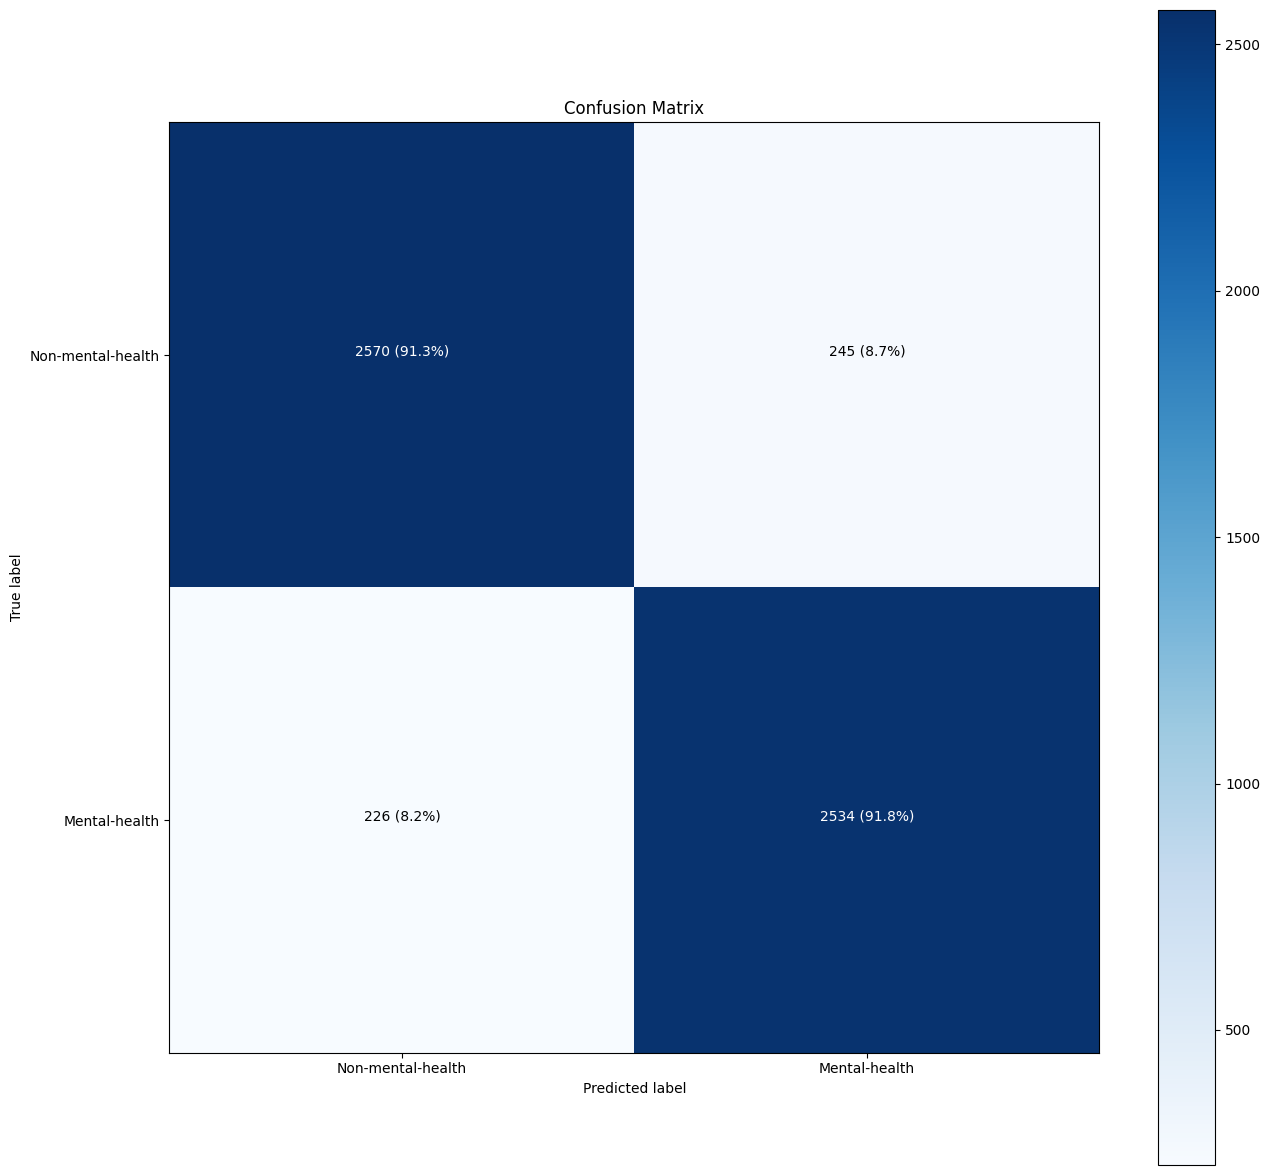

In [84]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=y_true,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

In [86]:
!pip install colorama
from colorama import Fore, Style
import numpy as np

def random_predictions(model, X_valid, y_valid, num_samples=5, class_names=None):
    # Check if it's binary or multi-class classification
    is_binary_classification = len(np.unique(y_valid)) == 2

    # Getting indices of the random samples
    random_indices = np.random.choice(np.arange(len(X_valid)), size=num_samples, replace=False)

    # Selecting the random samples
    random_X_samples = X_valid[random_indices]
    random_y_samples = y_valid[random_indices]

    # Making predictions on the random samples
    y_pred_probs = model.predict(random_X_samples)

    if is_binary_classification:
        y_pred = np.squeeze(np.round(y_pred_probs).astype(int))
    else:
        y_pred = np.argmax(y_pred_probs, axis=1)

    # Print the actual and predicted labels
    for i in range(num_samples):
        text = random_X_samples[i]
        true_label = random_y_samples[i] if is_binary_classification else np.argmax(random_y_samples[i])
        predicted_label = y_pred[i]

        # If class names are provided, use them for printing
        if class_names is not None:
            true_label_name = class_names[true_label]
            predicted_label_name = class_names[predicted_label]
        else:
            true_label_name = true_label
            predicted_label_name = predicted_label

        # Determine the color of the text (green for correct, red for incorrect)
        text_color = Fore.GREEN if true_label == predicted_label else Fore.RED

        print(f"\nSample {i + 1}:")
        print(f"Text: {text}")
        print(text_color + f"True: {true_label_name} \n Predicted: {predicted_label_name}" + Style.RESET_ALL)

In [87]:
random_predictions(lstm_model,
                   X_valid,
                   y_valid,
                   num_samples=20,
                   class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Sample 1:
Text: divorcewell look like im ruled doesnt matter ill dead make broke take kid
True: Mental-health 
 Predicted: Non-mental-health

Sample 2:
Text: slide done english doesnt suck much took hour slide hey progress finding image kinda fun
True: Non-mental-health 
 Predicted: Non-mental-health

Sample 3:
Text: asian pussy tight really wan na pipe oh god big as tiddys five
True: Non-mental-health 
 Predicted: Non-mental-health

Sample 4:
Text: count suicidal know fucking scared pain actually go anythingi want die want final minuteshours filled excruciating pain thing pill knife id never able idk guess needed say something want go sleep wake sorry waste everyones time
True: Mental-health 
 Predicted: Mental-health

Sample 5:
Text: im tiredim tired life im tired alone im tired horrible world want end
True: Mental-health 
 Predicted: Mental-health

Sample 6:
Text: losing continue husband last violent outburstlike title say already brink husband

The model_lstm is fit to the training data (X_train and y_train) for 10 epochs, with validation data (X_valid and y_valid) used for evaluation. The training progress is recorded in history_lstm, and the defined callbacks (cc) are utilized during training.

Post-training, the model's accuracy and loss evolution across epochs is visualized.

In [88]:
lstm_model.evaluate(X_valid, y_valid)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9104 - loss: 0.2309


[0.22536934912204742, 0.9155157208442688]

Class predictions are generated by transforming predicted probabilities on the validation dataset.

# **Model: GRU**

In [89]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)

from tensorflow.keras import layers
model_GRU_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_GRU")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_GRU_embedding(x)
x = layers.GRU(64, return_sequences=True)(x)  # Add parentheses here
x = layers.GRU(64)(x)
x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell

outputs = layers.Dense(1, activation="sigmoid")(x)

model_GRU = tf.keras.Model(inputs, outputs, name="model_GRU")

/Users/raja/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


The 'model_GRU' is compiled using the Adam optimizer and binary cross-entropy as the loss function, suitable for binary classification tasks.

In [90]:
# Compile GRU model
model_GRU.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [91]:
# Get a summary of the GRU model
model_GRU.summary()

Model: "model_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 232)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_GRU (Embedding)       │ (None, 232, 128)       │     7,482,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 232, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,549,313 (28.80 MB)

 Trainable params: 7,549,313 (28.80 MB)

 Non-trainable params: 0 (0.00 B)

A checkpoint callback is created for the GRU model.

In [92]:
# Define the checkpoint path
checkpoint_path = "best_model_GRU.keras"

cc = create_checkpoint_callback(checkpoint_path)

The improved  is fit to the training data (X_train and y_train) for 10 epochs, with validation data (X_valid and y_valid) used for evaluation. The training progress is recorded in model_GRU_history, and the defined callbacks (cc) are utilized during training.

In [93]:
# Fit model
model_GRU_history = model_GRU.fit(X_train, y_train,
                              epochs=10,
                              validation_data=(X_valid, y_valid),
                              callbacks=[cc])

Epoch 1/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5894 - loss: 0.6219
Epoch 1: val_accuracy improved from -inf to 0.91587, saving model to best_model_GRU.keras
697/697 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.5896 - loss: 0.6217 - val_accuracy: 0.9159 - val_loss: 0.2267
Epoch 2/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9235 - loss: 0.1994
Epoch 2: val_accuracy did not improve from 0.91587
697/697 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9236 - loss: 0.1994 - val_accuracy: 0.9132 - val_loss: 0.2286
Epoch 3/10
696/697 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9593 - loss: 0.1154
Epoch 3: val_accuracy did not improve from 0.91587
697/697 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9594 - loss: 0.1154 - val_accuracy: 0.8870 - val_loss: 0.3157
Epoch 4/10
697/697 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9786 - loss: 0.0696
Epoch 4: val_accuracy did not improve from 0.91587
697/697 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accurac

The model's accuracy and loss history is visualized post-training.

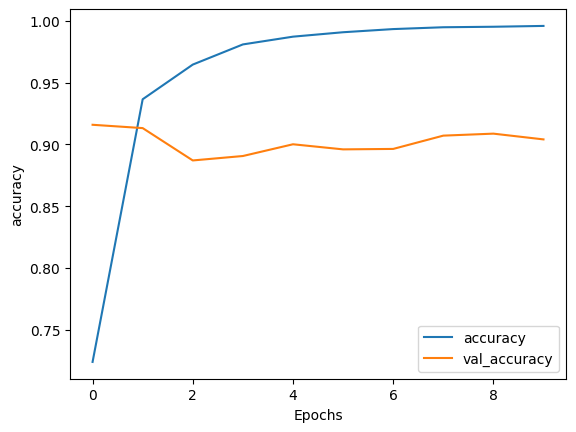

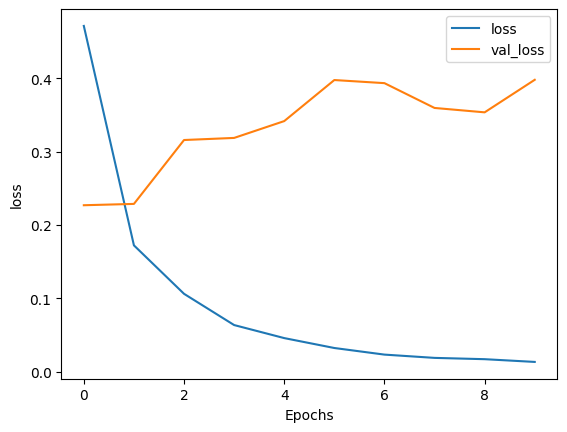

In [94]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(model_GRU_history, 'accuracy')
plot_graphs(model_GRU_history, 'loss')

In [95]:
# Load the entire model
model_GRU = load_model(checkpoint_path)

Model evaluation occurs on the validation set.

In [96]:
model_GRU.evaluate(X_valid, y_valid)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9120 - loss: 0.2298


[0.22674039006233215, 0.9158744215965271]

The model predicts probabilities on the validation set, converting these into class predictions.

In [97]:
# Make predictions on the validation data
model_GRU_pred_probs = model_GRU.predict(X_valid)
model_GRU_pred_probs.shape, model_GRU_pred_probs[:10]

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


((5575, 1),
 array([[0.32981187],
        [0.02121094],
        [0.9546341 ],
        [0.07093085],
        [0.7601235 ],
        [0.90935177],
        [0.91980696],
        [0.93996817],
        [0.9445129 ],
        [0.2996596 ]], dtype=float32))

In [98]:
# Convert prediction probabilities to labels
model_GRU_preds = tf.squeeze(tf.round(model_GRU_pred_probs))
model_GRU_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

Performance metrics, including accuracy, precision, recall, and F1-score, are computed for model evaluation.

In [99]:
# Calcuate model_GRU results
model_GRU_results = calculate_results(y_true=y_valid,
                                    y_pred=model_GRU_preds)
model_GRU_results

{'accuracy': 91.58744394618834,
 'precision': 0.9165497934850814,
 'recall': 0.9158744394618834,
 'f1': 0.9158214744588596}

The baseline model's performance is compared with the GRU model.

In [100]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_GRU_results)

Baseline accuracy: 85.43, New accuracy: 91.59, Difference: 6.15
Baseline precision: 0.88, New precision: 0.92, Difference: 0.04
Baseline recall: 0.85, New recall: 0.92, Difference: 0.06
Baseline f1: 0.85, New f1: 0.92, Difference: 0.06


In [101]:
y_true = y_valid.tolist()  # Convert labels to a list
preds = model_GRU.predict(X_valid)
y_probs = preds.squeeze().tolist()  # Store the prediction probabilities as a list
y_preds = tf.round(y_probs).numpy().tolist()  # Convert probabilities to class predictions and convert to a list


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


A confusion matrix is created for visualization of the model's classification performance. The matrix readability is enhanced via a custom function.

In [102]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_true,
                 y_pred=y_preds)

array([[2638,  177],
       [ 292, 2468]])

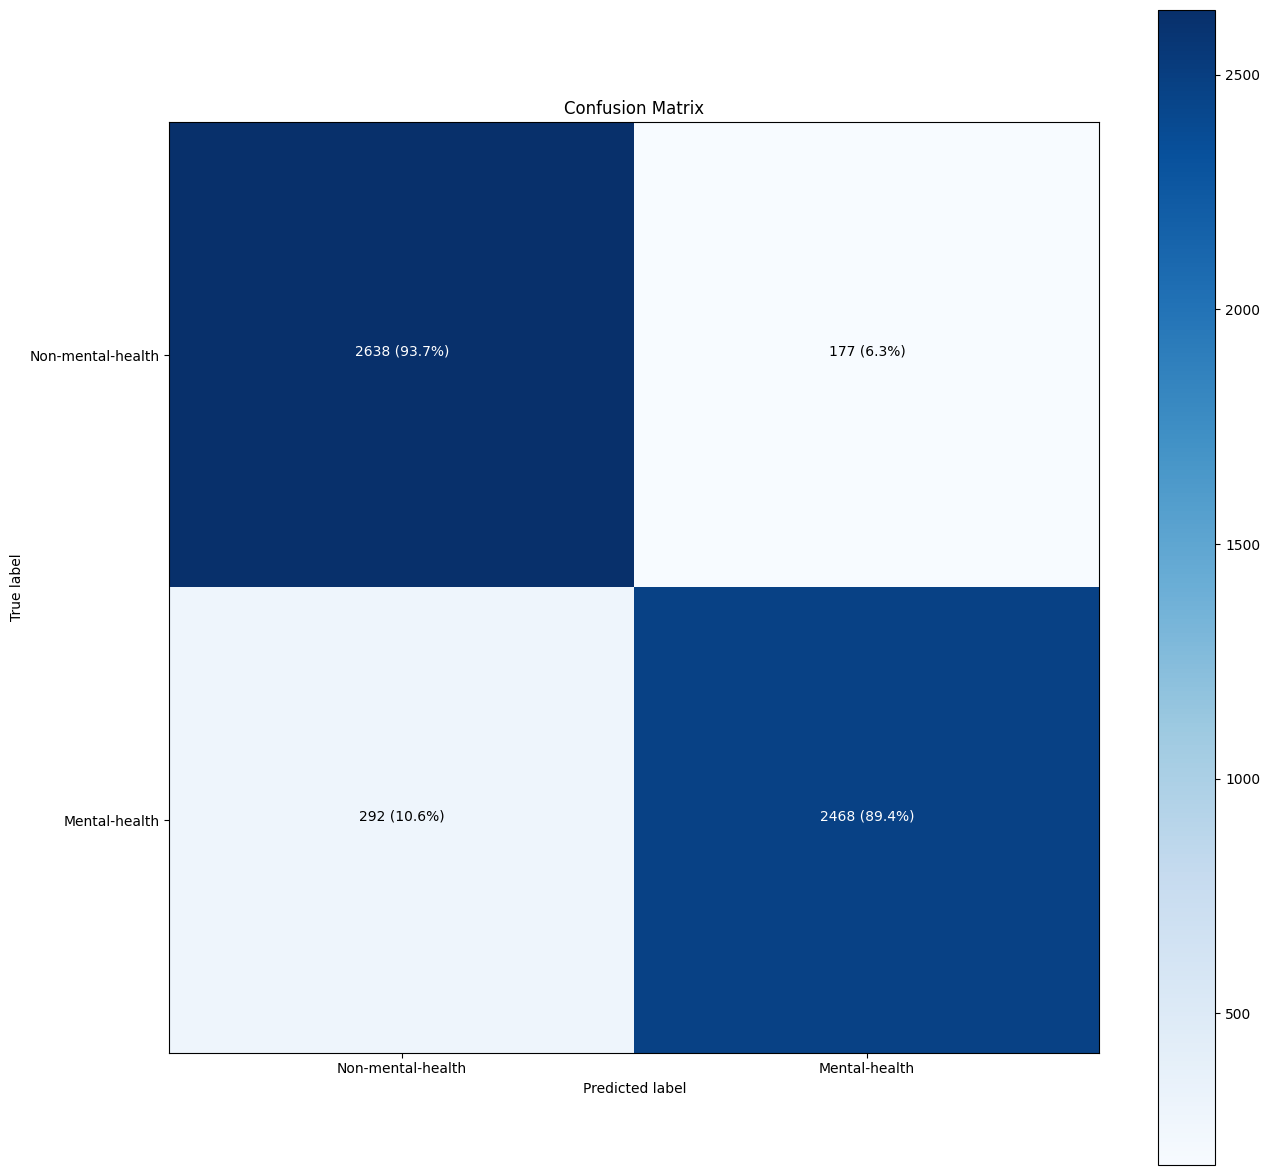

In [103]:
# Make a prettier confusion matrix
make_confusion_matrix(y_true=y_true,
                      y_pred=y_preds,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

Lastly, the 'random_predictions' function generates and displays predictions on random samples.

In [104]:
random_predictions(model_GRU,
                   X_valid,
                   y_valid,
                   num_samples=20,
                   class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Sample 1:
Text: financial crisis evicted house lost lighti feel like everythings gone shit fam financial problem year roll one day evicted cant shake feeling restlessness since need take care mum time back lost girl bcs got college like reason think shot spent le time going back almost always weekend whenever free time serious since family knew abt visited others place holiday everything went shit now miss lot year still feel yesterday tried go feel burnt seems happy friend lost world friend mine mind keep telling long happy cant foolmyself longer peace home study always feel like somethings going cant sleep want thing like go home see smile
True: Mental-health 
 Predicted: Mental-health

Sample 2:
Text: anybody first generation iphone se black reddit icon please hit youre going update please let know first really want black icon back
True: Non-mental-health 
 Predicted: Non-mental-health

Sample 3:
Text: biting bulletim year old drop working soft

## **Comparing all models**

In [105]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "LSTM": lstm_model_results,
                                  "GRU": model_GRU_results,
                                  })

all_model_results = all_model_results.transpose()
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.854350,0.881010,0.854350,0.851979
LSTM,0.915516,0.915541,0.915516,0.915518
GRU,0.915874,0.916550,0.915874,0.915821


In [106]:
all_model_results_sorted = all_model_results.sort_values("f1", ascending=False)
all_model_results_sorted

,accuracy,precision,recall,f1
GRU,0.915874,0.916550,0.915874,0.915821
LSTM,0.915516,0.915541,0.915516,0.915518
baseline,0.854350,0.881010,0.854350,0.851979


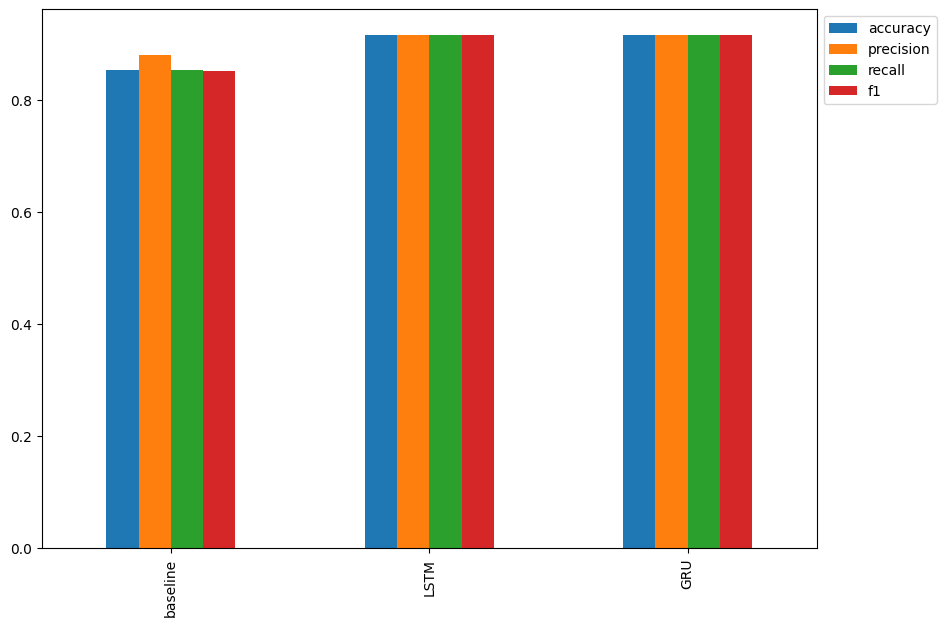

In [107]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

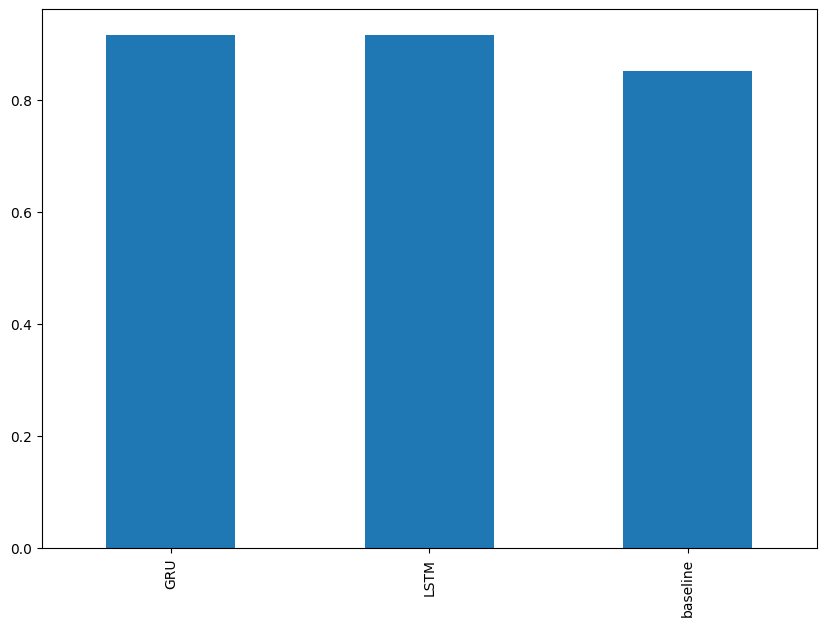

In [108]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

**Evaluation Metrics**

Moving forward, we will deploy the Model GRU for further analysis.

In [109]:
y_true = y_valid.tolist()  # Convert labels to a list
preds = model_GRU.predict(X_valid)
y_probs = preds.squeeze().tolist()  # Store the prediction probabilities as a list
y_preds = tf.round(y_probs).numpy().tolist()  # Convert probabilities to class predictions and convert to a list

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [110]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

report = classification_report(y_true, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      2815
           1       0.93      0.89      0.91      2760

    accuracy                           0.92      5575
   macro avg       0.92      0.92      0.92      5575
weighted avg       0.92      0.92      0.92      5575



# Ensemble Models

In [138]:
import numpy as np
import tensorflow as tf

# Get prediction probabilities
# Baseline model probabilities for the positive class
baseline_pred_probs = baseline_model.predict_proba(X_valid)[:, 1]

# LSTM and GRU model probabilities
lstm_pred_probs = lstm_model.predict(X_valid).flatten()
gru_pred_probs = model_GRU.predict(X_valid).flatten()

# Average the prediction probabilities
combined_pred_probs = (baseline_pred_probs + lstm_pred_probs + gru_pred_probs) / 3

# Convert averaged probabilities to binary predictions
combined_preds = tf.round(combined_pred_probs)

# Calculate ensemble results
ensemble_results = calculate_results(y_valid, combined_preds.numpy())
print("Ensemble Results:", ensemble_results)

# Add ensemble results to DataFrame for comparison
all_model_results.loc['Ensemble'] = {
    'accuracy': ensemble_results['accuracy'] / 100,  # Convert percentage if necessary
    'precision': ensemble_results['precision'],
    'recall': ensemble_results['recall'],
    'f1': ensemble_results['f1']
}
all_model_results

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Ensemble Results: {'accuracy': 92.46636771300449, 'precision': 0.9250171000796918, 'recall': 0.9246636771300448, 'f1': 0.9246593285796662}


,accuracy,precision,recall,f1
baseline,0.854350,0.881010,0.854350,0.851979
LSTM,0.915516,0.915541,0.915516,0.915518
GRU,0.915874,0.916550,0.915874,0.915821
Ensemble,0.924664,0.925017,0.924664,0.924659
